# USING SELINIUM AND BEAUTIFULSOUP TO WEBSCRAPE FOR MODEL DEVELOPMENT AND DEPLOYMENT

In [1]:
# Importing the needed libaries 
import requests
from selenium import webdriver
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.select import Select
import time
import re
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.feature_selection import mutual_info_regression
from matplotlib.ticker import FuncFormatter
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
import warnings
warnings.simplefilter(action = 'ignore')

## STEP 1: USING  SELINIUM TO NAVIGATE  TO THE EXTRACTION WEBSITE

In [ ]:
chromedriver_path =r"C:\Users\HP\Desktop\chromedriver.exe"

chrome_options = Options()
chrome_service = Service(chromedriver_path)

driver = webdriver.Chrome(service=chrome_service, options=chrome_options)

driver.get('https://nigeriapropertycentre.com/')

#driver.maximize_window()
#time.sleep(5)

# selecting for rent
rent = driver.find_element(By.ID, 'li-cid-for-rent')
rent.click()

# Filtering for Lagos
lagos= driver.find_element(By.CLASS_NAME, 'form-control')
lagos.send_keys('Lekki, Lagos')

#Filtering for houses 
house = driver.find_element (By.TAG_NAME, 'select')
dropdown = Select(house)
dropdown.select_by_visible_text('House')
time.sleep(2)

# clicking on search 
search = driver.find_element(By.XPATH, '//button[@class ="btn btn-lg btn-base btn-block"]')
search.click()

current_url = driver.current_url


######################

current_url

## STEP 2: PARSING URL TO BEAUTIFULSOUP FOR DATA EXTRACTION

In [ ]:
listings = []
url = current_url

for i in range(1, 229):
    url = f"{url}showtype?page={i}"
    response = requests.get(url)

    res = response.content
    soup = BeautifulSoup(res, 'html.parser')


    #Extracting all houses for rent on current page
    cards = soup.find_all('div', {'wp-block property list'})

    #Data to extract: DESCRIPTION, LOCATION, PRICE, BEDROOMS, TOILET, BATHROOMS, PARKING SPACE

    #Extracting a house description on current page
    cards[0].find('h4').get_text()

    #Extracting a house location on current page
    cards[0].find('address').get_text().strip()

    #Extracting a house price on current page
    cards[0].find('span', {'class': 'pull-sm-left'}).get_text().replace('per annum', "").strip().replace('₦', "").replace(',', "")

    #Extracting other information a the house ( the other house information consist of the bedrooms, bathrooms, toilets and parking space which will be separated later)
    cards[0].find('div', {'class': 'wp-block-footer'}).find('ul').get_text().replace(' Save', "")
    
    # Extracting all houses for rent on current page
    for result in cards:
        description = result.find('h4').get_text()
        location = result.find('address').get_text().strip()
        price = result.find('span', {'class': 'pull-sm-left'}).get_text().replace('per annum', "").strip().replace('₦', "").replace(',', "")
        others = result.find('div', {'class': 'wp-block-footer'}).find('ul').get_text().replace(' Save', "")
        
        listings.append([description, others, location, price])
        print(i)

In [21]:
listings

[['3 bedroom terraced duplex for rent',
  '3 Bedrooms3 Bathrooms4 Toilets2 Parking Spaces',
  'Orchid, Lekki, Lagos',
  '4700000'],
 ['3 bedroom terraced duplex for rent',
  '3 Bedrooms3 Bathrooms4 Toilets2 Parking Spaces',
  'Osapa, Lekki, Lagos',
  '4000000'],
 ['5 bedroom detached duplex for rent',
  '5 Bedrooms5 Bathrooms5 Toilets4 Parking Spaces',
  'Chevron, Lekki, Lagos',
  '7000000'],
 ['4 bedroom terraced duplex for rent',
  '4 Bedrooms4 Bathrooms5 Toilets3 Parking Spaces',
  'Ikota Gra, Ikota, Lekki, Lagos',
  '4000000'],
 ['4 bedroom semi-detached duplex for rent',
  '4 Bedrooms4 Bathrooms4 Toilets',
  'Lekki, Lagos',
  '4500000'],
 ['4 bedroom terraced duplex for rent',
  '4 Bedrooms4 Bathrooms4 Toilets',
  'Lekki, Lagos',
  '4500000'],
 ['4 bedroom semi-detached duplex for rent',
  '4 Bedrooms4 Bathrooms4 Toilets',
  'Orchid, Lekki, Lagos',
  '3000000'],
 ['1 bedroom house for rent',
  '1 Bedroom1 Bathroom2 Toilets',
  'Ikate, Ikate, Lekki, Lagos',
  '8000000'],
 ['3 bedro

In [22]:
# converting the extracted data into a dataframe
df = pd.DataFrame(listings, columns=['Description', 'Others', 'Location', 'Price'])

In [23]:
df.head(5)

,Description,Others,Location,Price
0,3 bedroom terraced duplex for rent,3 Bedrooms3 Bathrooms4 Toilets2 Parking Spaces,"Orchid, Lekki, Lagos",4700000
1,3 bedroom terraced duplex for rent,3 Bedrooms3 Bathrooms4 Toilets2 Parking Spaces,"Osapa, Lekki, Lagos",4000000
2,5 bedroom detached duplex for rent,5 Bedrooms5 Bathrooms5 Toilets4 Parking Spaces,"Chevron, Lekki, Lagos",7000000
3,4 bedroom terraced duplex for rent,4 Bedrooms4 Bathrooms5 Toilets3 Parking Spaces,"Ikota Gra, Ikota, Lekki, Lagos",4000000
4,4 bedroom semi-detached duplex for rent,4 Bedrooms4 Bathrooms4 Toilets,"Lekki, Lagos",4500000


## STEP 3: DATA CLEANING

In [24]:
# Creating a Function to split the 'Others' column and handle missing values
def split_others(others):
    # Initialize with None
    bedrooms, bathrooms, toilets, parking_spaces = np.nan, np.nan, np.nan, np.nan
    
    # Use regex to find the patterns
    bedrooms_match = re.search(r'(\d+) Bedrooms?', others)
    bathrooms_match = re.search(r'(\d+) Bathrooms?', others)
    toilets_match = re.search(r'(\d+) Toilets?', others)
    parking_spaces_match = re.search(r'(\d+) Parking Spaces?', others)

    if bedrooms_match:
        bedrooms = bedrooms_match.group(1)
    if bathrooms_match:
        bathrooms = bathrooms_match.group(1)
    if toilets_match:
        toilets = toilets_match.group(1)
    if parking_spaces_match:
        parking_spaces = parking_spaces_match.group(1)
    
    return pd.Series([bedrooms, bathrooms, toilets, parking_spaces])


# Applying the function to the 'Others' column
df[['Total Bedrooms', 'Total Bathrooms', 'Total Toilets', 'Parking Spaces']] = df['Others'].apply(split_others)

df

,Description,Others,Location,Price,Total Bedrooms,Total Bathrooms,Total Toilets,Parking Spaces
0,3 bedroom terraced duplex for rent,3 Bedrooms3 Bathrooms4 Toilets2 Parking Spaces,"Orchid, Lekki, Lagos",4700000,3,3,4,2
1,3 bedroom terraced duplex for rent,3 Bedrooms3 Bathrooms4 Toilets2 Parking Spaces,"Osapa, Lekki, Lagos",4000000,3,3,4,2
2,5 bedroom detached duplex for rent,5 Bedrooms5 Bathrooms5 Toilets4 Parking Spaces,"Chevron, Lekki, Lagos",7000000,5,5,5,4
3,4 bedroom terraced duplex for rent,4 Bedrooms4 Bathrooms5 Toilets3 Parking Spaces,"Ikota Gra, Ikota, Lekki, Lagos",4000000,4,4,5,3
4,4 bedroom semi-detached duplex for rent,4 Bedrooms4 Bathrooms4 Toilets,"Lekki, Lagos",4500000,4,4,4,NaN
...,...,...,...,...,...,...,...,...
4783,2 bedroom house for rent,2 Bedrooms2 Bathrooms3 Toilets,"Ologolo, Lekki, Lagos",3500000,2,2,3,NaN
4784,2 bedroom house for rent,2 Bedrooms2 Bathrooms3 Toilets2 Parking Spaces,"Salem Ikate Elegunshi Edwin Close, Ikate Elegu...",4000000,2,2,3,2
4785,4 bedroom semi-detached duplex for rent,4 Bedrooms4 Bathrooms5 Toilets,"Orchid, Lekki, Lekki, Lagos",7000000,4,4,5,NaN
4786,3 bedroom terraced duplex for rent,3 Bedrooms3 Bathrooms3 Toilets2 Parking Spaces,"Ikota Villa Gra, Ikota, Lekki, Lagos",3500000,3,3,3,2


In [25]:
# Splitting the 'Description' column
df[['Bedrooms', 'Type']] = df['Description'].str.extract(r'(\d+ bedroom) (.+) for rent')
df

,Description,Others,Location,Price,Total Bedrooms,Total Bathrooms,Total Toilets,Parking Spaces,Bedrooms,Type
0,3 bedroom terraced duplex for rent,3 Bedrooms3 Bathrooms4 Toilets2 Parking Spaces,"Orchid, Lekki, Lagos",4700000,3,3,4,2,3 bedroom,terraced duplex
1,3 bedroom terraced duplex for rent,3 Bedrooms3 Bathrooms4 Toilets2 Parking Spaces,"Osapa, Lekki, Lagos",4000000,3,3,4,2,3 bedroom,terraced duplex
2,5 bedroom detached duplex for rent,5 Bedrooms5 Bathrooms5 Toilets4 Parking Spaces,"Chevron, Lekki, Lagos",7000000,5,5,5,4,5 bedroom,detached duplex
3,4 bedroom terraced duplex for rent,4 Bedrooms4 Bathrooms5 Toilets3 Parking Spaces,"Ikota Gra, Ikota, Lekki, Lagos",4000000,4,4,5,3,4 bedroom,terraced duplex
4,4 bedroom semi-detached duplex for rent,4 Bedrooms4 Bathrooms4 Toilets,"Lekki, Lagos",4500000,4,4,4,NaN,4 bedroom,semi-detached duplex
...,...,...,...,...,...,...,...,...,...,...
4783,2 bedroom house for rent,2 Bedrooms2 Bathrooms3 Toilets,"Ologolo, Lekki, Lagos",3500000,2,2,3,NaN,2 bedroom,house
4784,2 bedroom house for rent,2 Bedrooms2 Bathrooms3 Toilets2 Parking Spaces,"Salem Ikate Elegunshi Edwin Close, Ikate Elegu...",4000000,2,2,3,2,2 bedroom,house
4785,4 bedroom semi-detached duplex for rent,4 Bedrooms4 Bathrooms5 Toilets,"Orchid, Lekki, Lekki, Lagos",7000000,4,4,5,NaN,4 bedroom,semi-detached duplex
4786,3 bedroom terraced duplex for rent,3 Bedrooms3 Bathrooms3 Toilets2 Parking Spaces,"Ikota Villa Gra, Ikota, Lekki, Lagos",3500000,3,3,3,2,3 bedroom,terraced duplex


In [26]:
df["Location"].unique()

array(['Orchid, Lekki, Lagos', 'Osapa, Lekki, Lagos',
       'Chevron, Lekki, Lagos', 'Ikota Gra, Ikota, Lekki, Lagos',
       'Lekki, Lagos', 'Ikate, Ikate, Lekki, Lagos',
       'Orchid Road, Lekki, Lagos',
       'Off Admiralty Way, Lekki Phase 1, Lekki, Lagos',
       'Ikate, Lekki, Lagos', 'Ikota, Lekki, Lagos',
       'Hrc Estate By Harris Drive, Ikota, By Vgc, Ikota, Lekki, Lagos',
       'Ologolo, Lekki, Lagos',
       'Salem Ikate Elegunshi Edwin Close, Ikate Elegushi, Lekki, Lagos',
       'Orchid, Lekki, Lekki, Lagos',
       'Ikota Villa Gra, Ikota, Lekki, Lagos'], dtype=object)

In [27]:
# checking the data categories in the location column
df["Location"].value_counts()

Location
Lekki, Lagos                                                       684
Orchid, Lekki, Lagos                                               456
Osapa, Lekki, Lagos                                                456
Chevron, Lekki, Lagos                                              456
Ikota, Lekki, Lagos                                                456
Ikota Gra, Ikota, Lekki, Lagos                                     228
Ikate, Ikate, Lekki, Lagos                                         228
Orchid Road, Lekki, Lagos                                          228
Off Admiralty Way, Lekki Phase 1, Lekki, Lagos                     228
Ikate, Lekki, Lagos                                                228
Hrc Estate By Harris Drive, Ikota, By Vgc, Ikota, Lekki, Lagos     228
Ologolo, Lekki, Lagos                                              228
Salem Ikate Elegunshi Edwin Close, Ikate Elegushi, Lekki, Lagos    228
Orchid, Lekki, Lekki, Lagos                                        2

In [28]:
# Define your keywords
keywords = ['Lekki Phase 1', 'Chevron', 'Orchid', 'Ikate', 'Ikota', 'Osapa', 'Lekki']

# Creating a Function to extract keywords from location column
def extract_keyword(location, keywords):
    for keyword in keywords:
        if keyword in location:
            return keyword
    return 'Other'

# Appling the function to the Location column
df['Simplified Location'] = df['Location'].apply(lambda x: extract_keyword(x, keywords))
df.head(20)

,Description,Others,Location,Price,Total Bedrooms,Total Bathrooms,Total Toilets,Parking Spaces,Bedrooms,Type,Simplified Location
0,3 bedroom terraced duplex for rent,3 Bedrooms3 Bathrooms4 Toilets2 Parking Spaces,"Orchid, Lekki, Lagos",4700000,3,3,4,2,3 bedroom,terraced duplex,Orchid
1,3 bedroom terraced duplex for rent,3 Bedrooms3 Bathrooms4 Toilets2 Parking Spaces,"Osapa, Lekki, Lagos",4000000,3,3,4,2,3 bedroom,terraced duplex,Osapa
2,5 bedroom detached duplex for rent,5 Bedrooms5 Bathrooms5 Toilets4 Parking Spaces,"Chevron, Lekki, Lagos",7000000,5,5,5,4,5 bedroom,detached duplex,Chevron
3,4 bedroom terraced duplex for rent,4 Bedrooms4 Bathrooms5 Toilets3 Parking Spaces,"Ikota Gra, Ikota, Lekki, Lagos",4000000,4,4,5,3,4 bedroom,terraced duplex,Ikota
4,4 bedroom semi-detached duplex for rent,4 Bedrooms4 Bathrooms4 Toilets,"Lekki, Lagos",4500000,4,4,4,NaN,4 bedroom,semi-detached duplex,Lekki
5,4 bedroom terraced duplex for rent,4 Bedrooms4 Bathrooms4 Toilets,"Lekki, Lagos",4500000,4,4,4,NaN,4 bedroom,terraced duplex,Lekki
6,4 bedroom semi-detached duplex for rent,4 Bedrooms4 Bathrooms4 Toilets,"Orchid, Lekki, Lagos",3000000,4,4,4,NaN,4 bedroom,semi-detached duplex,Orchid
7,1 bedroom house for rent,1 Bedroom1 Bathroom2 Toilets,"Ikate, Ikate, Lekki, Lagos",8000000,1,1,2,NaN,1 bedroom,house,Ikate
8,3 bedroom detached duplex for rent,3 Bedrooms3 Bathrooms4 Toilets3 Parking Spaces,"Orchid Road, Lekki, Lagos",4000000,3,3,4,3,3 bedroom,detached duplex,Orchid
9,5 bedroom semi-detached duplex for rent,5 Bedrooms5 Bathrooms6 Toilets3 Parking Spaces,"Osapa, Lekki, Lagos",6500000,5,5,6,3,5 bedroom,semi-detached duplex,Osapa


In [30]:
# checking the data categories in the simplified location column
df["Simplified Location"].value_counts()

Simplified Location
Ikota            1140
Orchid            912
Lekki             912
Ikate             684
Osapa             456
Chevron           456
Lekki Phase 1     228
Name: count, dtype: int64

In [31]:
# checking the data categories in the Type column
df["Type"].unique()

array(['terraced duplex', 'detached duplex', 'semi-detached duplex',
       'house'], dtype=object)

In [32]:
# Dropping the columns that has been extracted
df = df.drop(columns=['Description','Bedrooms', 'Location', 'Others'], axis = 1)
df

,Price,Total Bedrooms,Total Bathrooms,Total Toilets,Parking Spaces,Type,Simplified Location
0,4700000,3,3,4,2,terraced duplex,Orchid
1,4000000,3,3,4,2,terraced duplex,Osapa
2,7000000,5,5,5,4,detached duplex,Chevron
3,4000000,4,4,5,3,terraced duplex,Ikota
4,4500000,4,4,4,NaN,semi-detached duplex,Lekki
...,...,...,...,...,...,...,...
4783,3500000,2,2,3,NaN,house,Lekki
4784,4000000,2,2,3,2,house,Ikate
4785,7000000,4,4,5,NaN,semi-detached duplex,Orchid
4786,3500000,3,3,3,2,terraced duplex,Ikota


In [33]:
# Renaming column names
df = df.rename(columns={
    'Price': 'Price/annum',
    'Total Bedrooms': 'Bedrooms',
    'Total Bathrooms': 'Bathrooms',
    'Total Toilets': 'Toilets',
    'Parking Spaces': 'Parking Spaces',
    'Type': 'House_type',
    'Simplified Location': 'Location'
})

# Rearranging columns
df = df[['House_type', 'Bedrooms', 'Bathrooms', 'Toilets', 'Parking Spaces', 'Location', 'Price/annum']]
df.head(20)

,House_type,Bedrooms,Bathrooms,Toilets,Parking Spaces,Location,Price/annum
0,terraced duplex,3,3,4,2,Orchid,4700000
1,terraced duplex,3,3,4,2,Osapa,4000000
2,detached duplex,5,5,5,4,Chevron,7000000
3,terraced duplex,4,4,5,3,Ikota,4000000
4,semi-detached duplex,4,4,4,NaN,Lekki,4500000
5,terraced duplex,4,4,4,NaN,Lekki,4500000
6,semi-detached duplex,4,4,4,NaN,Orchid,3000000
7,house,1,1,2,NaN,Ikate,8000000
8,detached duplex,3,3,4,3,Orchid,4000000
9,semi-detached duplex,5,5,6,3,Osapa,6500000


In [34]:
# Save to CSV 
df.to_csv("propertycenter_data(Lekki,Lagos).csv", index=False)

## STEP 4: EXPLORATORY DATA ANALYSIS

In [3]:
#importing the extracted file
df = pd.read_csv("propertycenter_data(Lekki,Lagos).csv")
df.head()

,House_type,Bedrooms,Bathrooms,Toilets,Parking Spaces,Location,Price/annum
0,terraced duplex,3,3,4,2.0,Orchid,4700000
1,terraced duplex,3,3,4,2.0,Osapa,4000000
2,detached duplex,5,5,5,4.0,Chevron,7000000
3,terraced duplex,4,4,5,3.0,Ikota,4000000
4,semi-detached duplex,4,4,4,NaN,Lekki,4500000


In [6]:
df['House_type'] = df['House_type'].replace('house', 'apartment')
df['Location'] = df['Location'].replace('Lekki', 'Ibeju-Lekki')
df['Location'].unique()

array(['Orchid', 'Osapa', 'Chevron', 'Ikota', 'Ibeju-Lekki', 'Ikate',
       'Lekki Phase 1'], dtype=object)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4788 entries, 0 to 4787
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   House_type      4788 non-null   object 
 1   Bedrooms        4788 non-null   int64  
 2   Bathrooms       4788 non-null   int64  
 3   Toilets         4788 non-null   int64  
 4   Parking Spaces  3192 non-null   float64
 5   Location        4788 non-null   object 
 6   Price/annum     4788 non-null   int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 262.0+ KB


In [9]:
# Summary statistics for numerical columns
df.describe(include = 'all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
House_type,4788,4,terraced duplex,2052,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bedrooms,4788.0,NaN,NaN,NaN,3.571429,1.0035,1.0,3.0,4.0,4.0,5.0
Bathrooms,4788.0,NaN,NaN,NaN,3.571429,1.0035,1.0,3.0,4.0,4.0,5.0
Toilets,4788.0,NaN,NaN,NaN,4.333333,0.992135,2.0,4.0,4.0,5.0,6.0
Parking Spaces,3192.0,NaN,NaN,NaN,2.857143,1.059623,2.0,2.0,3.0,3.0,6.0
Location,4788,7,Ikota,1140,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Price/annum,4788.0,NaN,NaN,NaN,5628571.428571,2445297.556467,3000000.0,4000000.0,4500000.0,7000000.0,12000000.0


In [12]:
#observation:

In [14]:
# Checking for missing values
print(df.isna().sum())

House_type           0
Bedrooms             0
Bathrooms            0
Toilets              0
Parking Spaces    1596
Location             0
Price/annum          0
dtype: int64


In [15]:
#observation:

### EDA ON THE NUMERICAL FEATURES

<Axes: xlabel='Bedrooms', ylabel='count'>

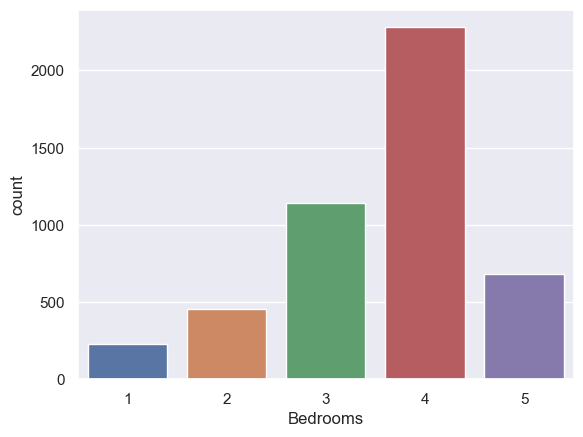

In [17]:
sns.countplot(data = df, x = 'Bedrooms')

<Axes: xlabel='Bathrooms', ylabel='count'>

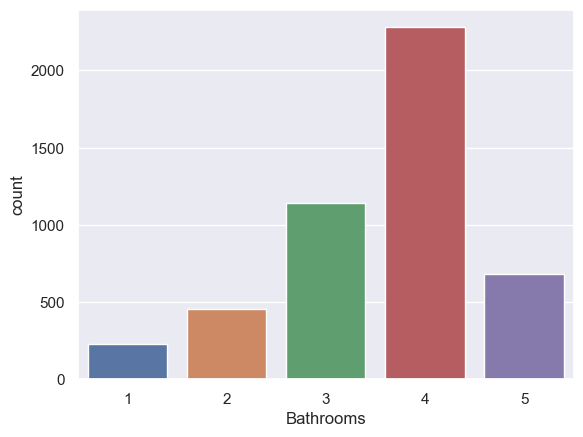

In [19]:
sns.countplot(data = df, x = 'Bathrooms')

<Axes: xlabel='Toilets', ylabel='count'>

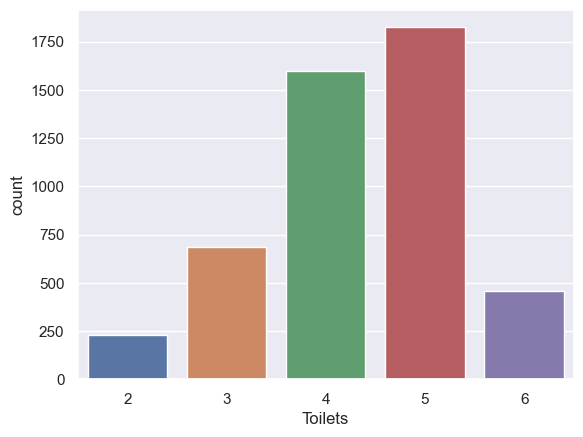

In [20]:
sns.countplot(data = df, x = 'Toilets')

<Axes: xlabel='Parking Spaces', ylabel='count'>

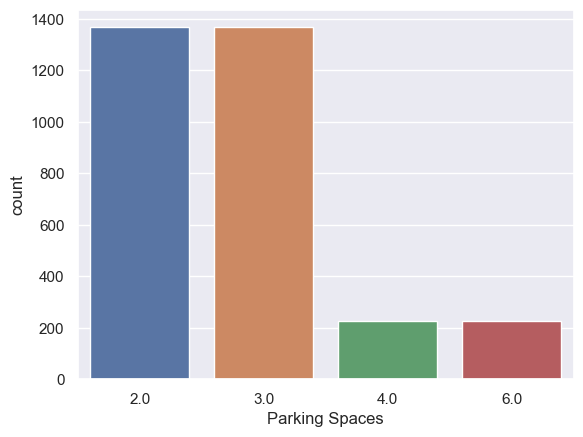

In [21]:
sns.countplot(data = df, x = 'Parking Spaces')

<Axes: xlabel='Price/annum', ylabel='count'>

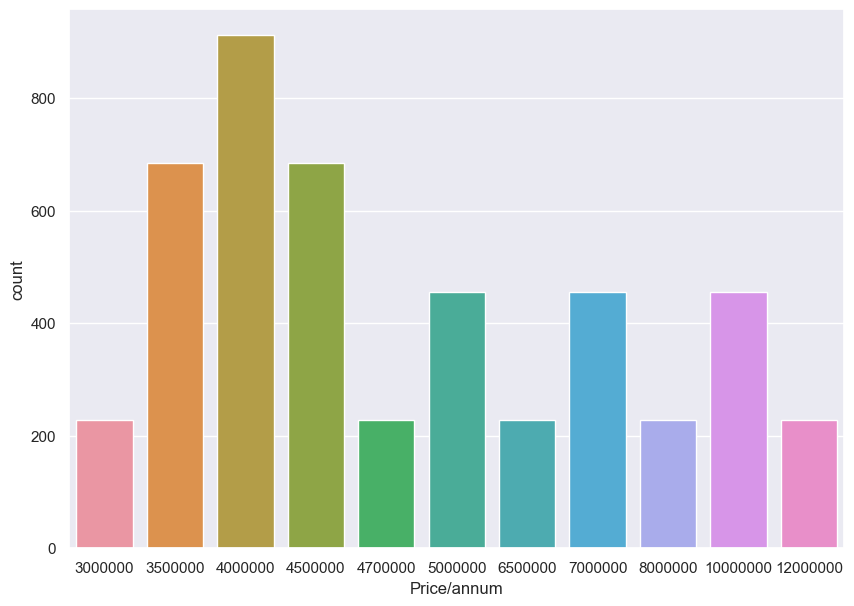

In [22]:
plt.figure(figsize= (10, 7))
sns.countplot(data = df, x = 'Price/annum')

In [23]:
df.isna().sum()

House_type           0
Bedrooms             0
Bathrooms            0
Toilets              0
Parking Spaces    1596
Location             0
Price/annum          0
dtype: int64

In [24]:
# Filling the NaN values in 'Parking Spaces' with 0
df['Parking Spaces'] = df['Parking Spaces'].fillna(0)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4788 entries, 0 to 4787
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   House_type      4788 non-null   object 
 1   Bedrooms        4788 non-null   int64  
 2   Bathrooms       4788 non-null   int64  
 3   Toilets         4788 non-null   int64  
 4   Parking Spaces  4788 non-null   float64
 5   Location        4788 non-null   object 
 6   Price/annum     4788 non-null   int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 262.0+ KB


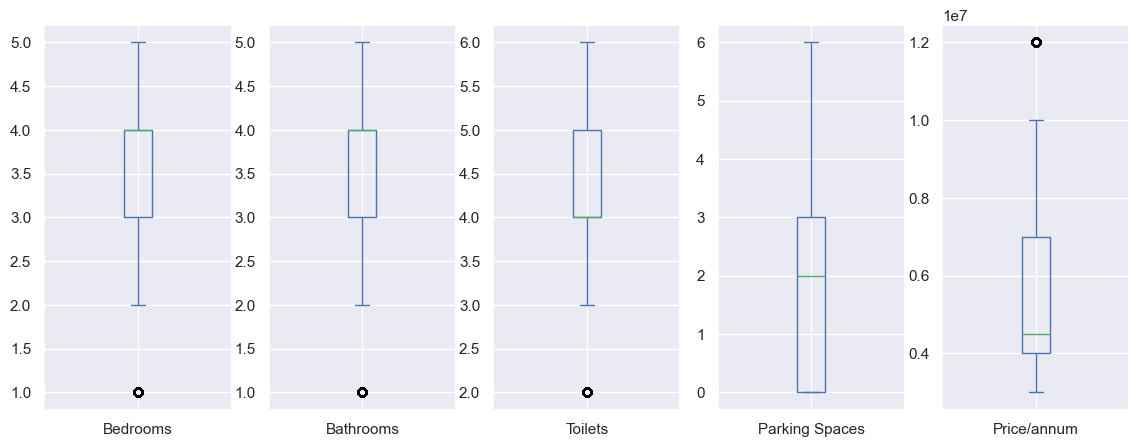

In [28]:
# Checking for outliers on the numerical columns

numerical_columns = ['Bedrooms', 'Bathrooms', 'Toilets', 'Parking Spaces', 'Price/annum']

df[numerical_columns].plot(
    kind = 'box',
    figsize = (14, 5),
    subplots = True
);

In [30]:
# Calculate Q1 and Q3 for each numerical column
numerical_columns = ['Bedrooms', 'Bathrooms', 'Toilets', 'Parking Spaces', 'Price/annum']

Q1 = df[numerical_columns].quantile(0.25)
Q3 = df[numerical_columns].quantile(0.75)

# Calculate IQR for each numerical column
IQR = Q3 - Q1

# Determine outlier bounds for each numerical column
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers for each numerical column
outliers = pd.DataFrame()

for column in numerical_columns:
    outlier_mask = (df[column] < lower_bound[column]) | (df[column] > upper_bound[column])
    outliers = pd.concat([outliers, df[column][outlier_mask]], axis=1)
outliers

,Bedrooms,Bathrooms,Toilets,Parking Spaces,Price/annum
7,1.0,1.0,2.0,NaN,NaN
28,1.0,1.0,2.0,NaN,NaN
49,1.0,1.0,2.0,NaN,NaN
70,1.0,1.0,2.0,NaN,NaN
91,1.0,1.0,2.0,NaN,NaN
...,...,...,...,...,...
4693,NaN,NaN,NaN,NaN,12000000.0
4714,NaN,NaN,NaN,NaN,12000000.0
4735,NaN,NaN,NaN,NaN,12000000.0
4756,NaN,NaN,NaN,NaN,12000000.0


In [31]:
outliers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 456 entries, 7 to 4777
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Bedrooms        228 non-null    float64
 1   Bathrooms       228 non-null    float64
 2   Toilets         228 non-null    float64
 3   Parking Spaces  0 non-null      float64
 4   Price/annum     228 non-null    float64
dtypes: float64(5)
memory usage: 21.4 KB


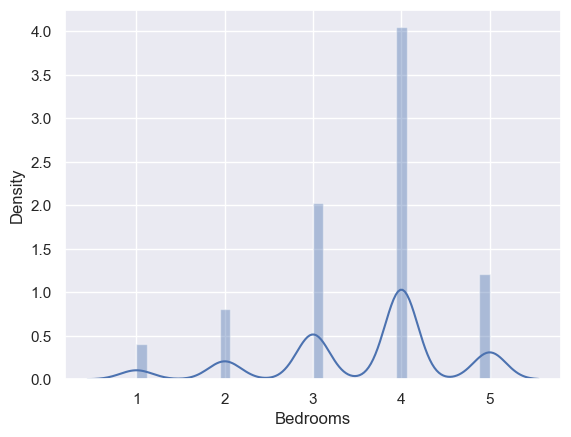

In [32]:
sns.distplot(df['Bedrooms']);

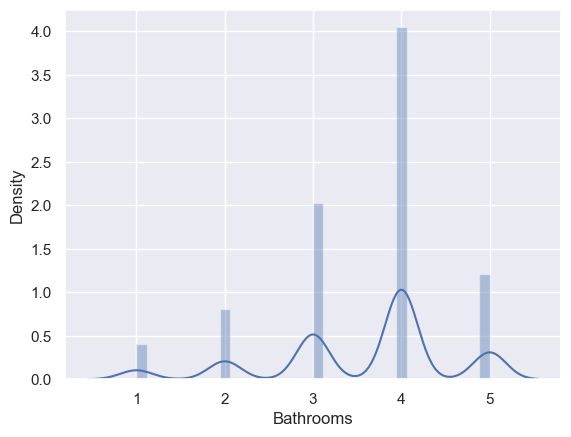

In [33]:
sns.distplot(df['Bathrooms']);

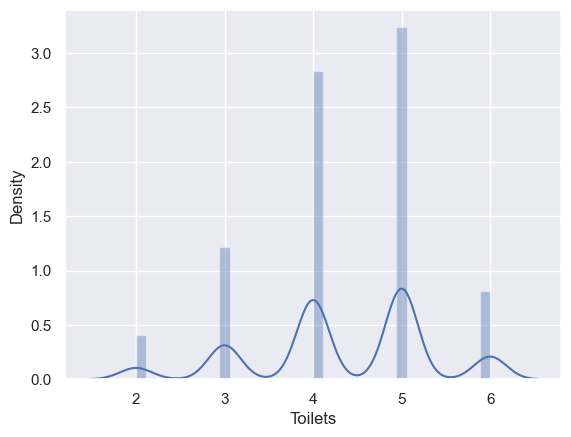

In [34]:
sns.distplot(df['Toilets']);

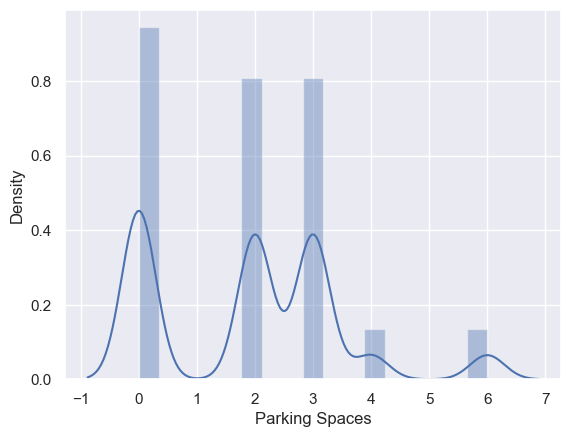

In [35]:
sns.distplot(df['Parking Spaces']);

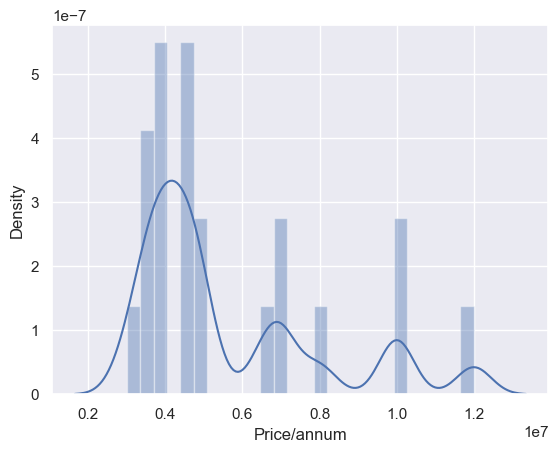

In [36]:
sns.distplot(df['Price/annum']);

#### Using the Removal Method To Remove Outliers

In [39]:
# Filter out rows with outliers
df1 = df.copy()
for column in numerical_columns:
    df1 = df1[(df1[column] >= lower_bound[column]) & (df1[column] <= upper_bound[column])]
df1

,House_type,Bedrooms,Bathrooms,Toilets,Parking Spaces,Location,Price/annum
0,terraced duplex,3,3,4,2.0,Orchid,4700000
1,terraced duplex,3,3,4,2.0,Osapa,4000000
2,detached duplex,5,5,5,4.0,Chevron,7000000
3,terraced duplex,4,4,5,3.0,Ikota,4000000
4,semi-detached duplex,4,4,4,0.0,Ibeju-Lekki,4500000
...,...,...,...,...,...,...,...
4783,apartment,2,2,3,0.0,Ibeju-Lekki,3500000
4784,apartment,2,2,3,2.0,Ikate,4000000
4785,semi-detached duplex,4,4,5,0.0,Orchid,7000000
4786,terraced duplex,3,3,3,2.0,Ikota,3500000


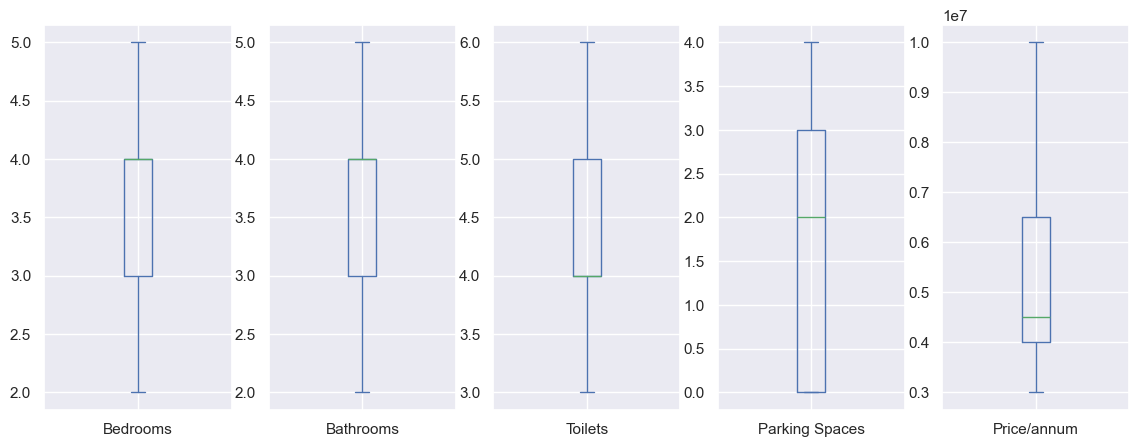

In [40]:
# Rechecking for outliers on the numerical columns

numerical_columns = ['Bedrooms', 'Bathrooms', 'Toilets', 'Parking Spaces', 'Price/annum']

df1[numerical_columns].plot(
    kind = 'box',
    figsize = (14, 5),
    subplots = True
);

In [41]:
#observation:

In [42]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4332 entries, 0 to 4787
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   House_type      4332 non-null   object 
 1   Bedrooms        4332 non-null   int64  
 2   Bathrooms       4332 non-null   int64  
 3   Toilets         4332 non-null   int64  
 4   Parking Spaces  4332 non-null   float64
 5   Location        4332 non-null   object 
 6   Price/annum     4332 non-null   int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 270.8+ KB


In [43]:
df.columns

Index(['House_type', 'Bedrooms', 'Bathrooms', 'Toilets', 'Parking Spaces',
       'Location', 'Price/annum'],
      dtype='object')

In [44]:
cat_features = ['House_type', 'Location']
num_features =['Bedrooms', 'Bathrooms', 'Toilets', 'Parking Spaces', 'Price/annum']

In [45]:
# lets explore the correlation between the continous feature variables
# Checking the correlation between the numerical features
correlation = df[num_features].corr()
correlation

,Bedrooms,Bathrooms,Toilets,Parking Spaces,Price/annum
Bedrooms,1.000000,1.000000,0.908943,0.360006,0.300021
Bathrooms,1.000000,1.000000,0.908943,0.360006,0.300021
Toilets,0.908943,0.908943,1.000000,0.469799,0.414239
Parking Spaces,0.360006,0.360006,0.469799,1.000000,0.508049
Price/annum,0.300021,0.300021,0.414239,0.508049,1.000000


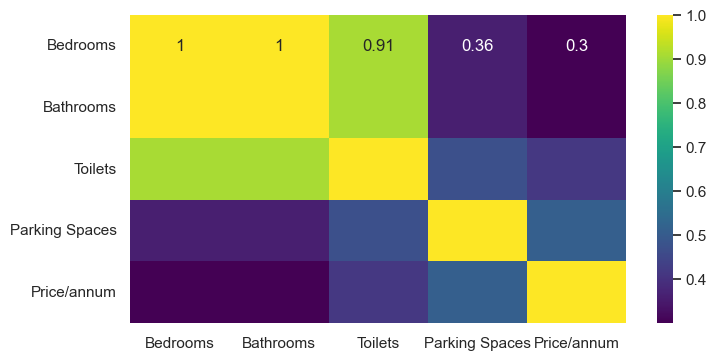

In [47]:
# visualizing the correlation using a heatmap
plt.figure(figsize=(8,4))
sns.heatmap(correlation,annot = True,cmap= 'viridis')
plt.show()

In [48]:
# Observation:

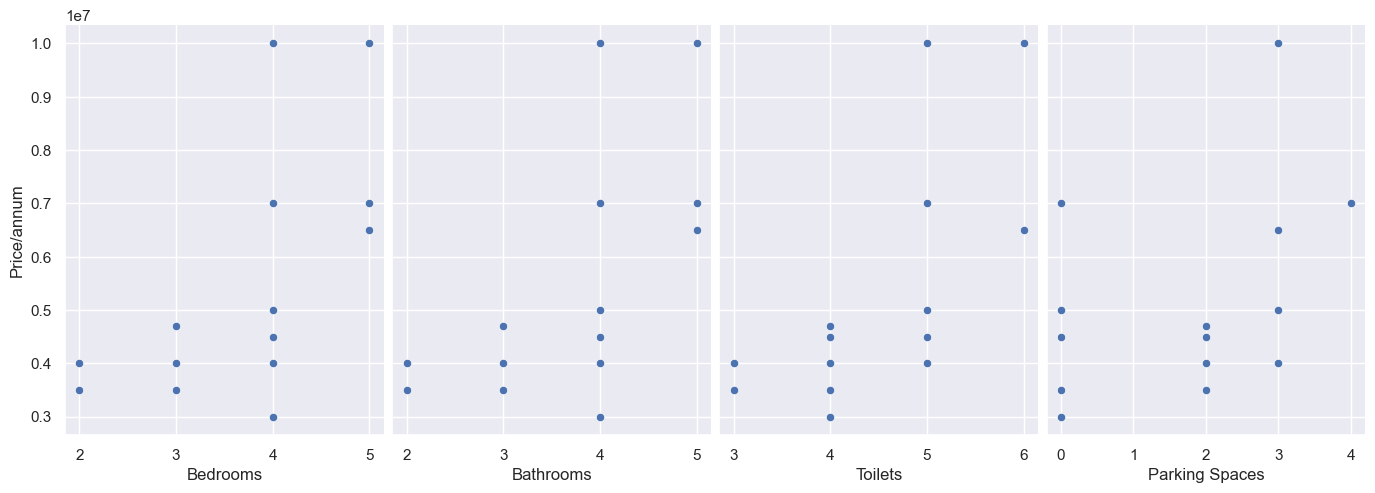

In [49]:
# Checking the interactions between the numerical features
sns.pairplot(df1, x_vars=['Bedrooms', 'Bathrooms', 'Toilets', 'Parking Spaces'], y_vars='Price/annum', height=5, aspect=0.7)
plt.show()

### EDA ON THE CATEGORICAL FEATURE

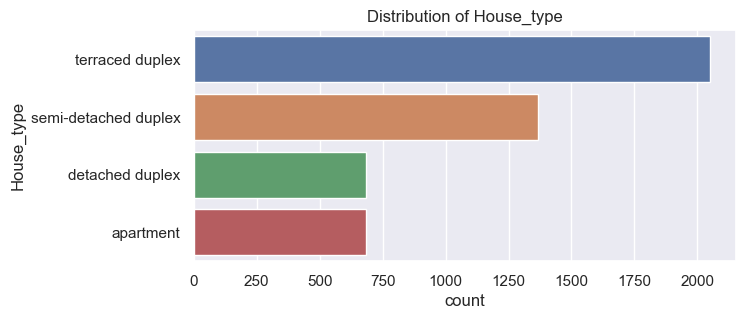

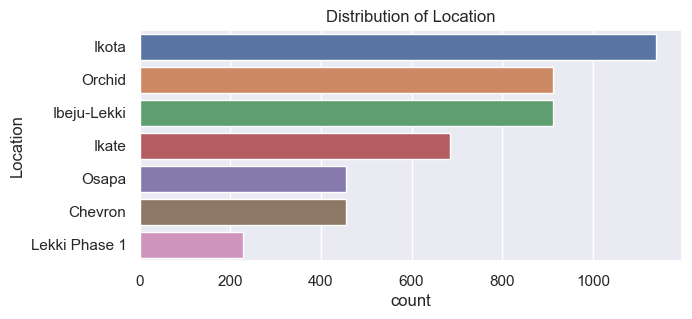

In [52]:
# Data distribution for categorical columns
categorical_columns = ['House_type', 'Location']

for col in categorical_columns:
    plt.figure(figsize=(7, 3))
    sns.countplot(y=col, data=df, order=df[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.show()

In [54]:
# Observation:

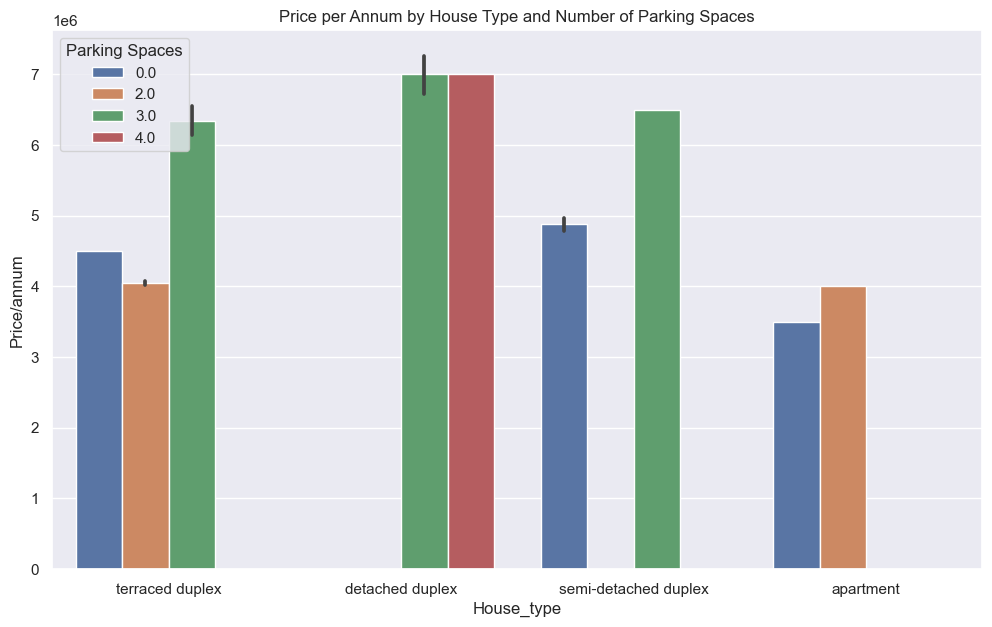

In [55]:
# House prices per annum for each house type, splited by the number of parking spaces.
plt.figure(figsize=(12, 7))
sns.barplot(x='House_type', y='Price/annum', hue='Parking Spaces', data=df1)
plt.title('Price per Annum by House Type and Number of Parking Spaces')
plt.show()

In [61]:
# Observation:

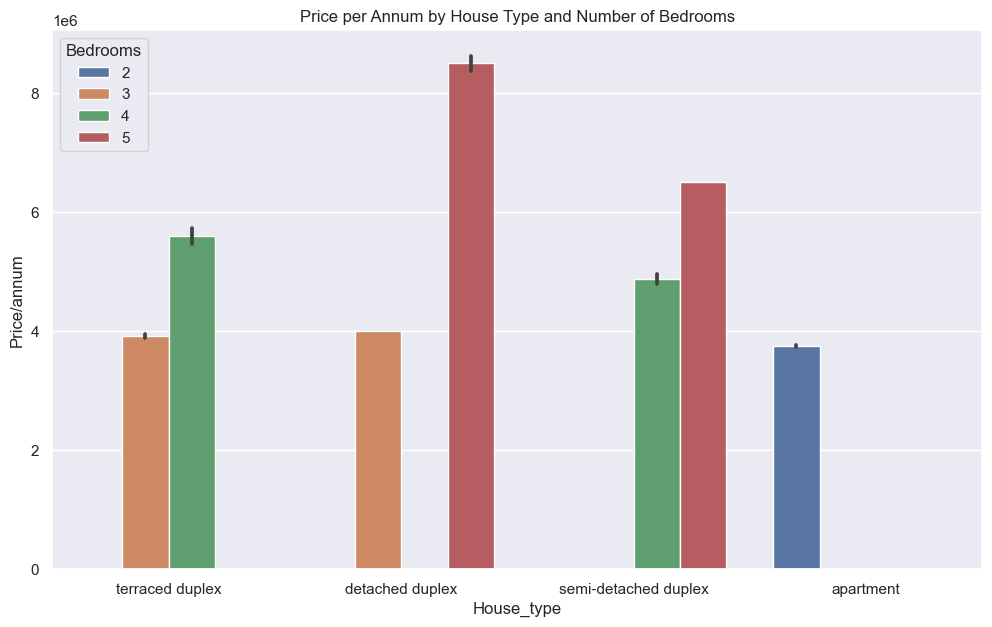

In [62]:
# House prices per annum for each house type, splited by the number of Bedrooms.
plt.figure(figsize=(12, 7))
sns.barplot(x='House_type', y='Price/annum', hue='Bedrooms', data=df1)
plt.title('Price per Annum by House Type and Number of Bedrooms')
plt.show()

In [63]:
# Observation:

#### GROUP ANALYSIS (Calculating the mean price/annum for each subcategory in the Categorical features)

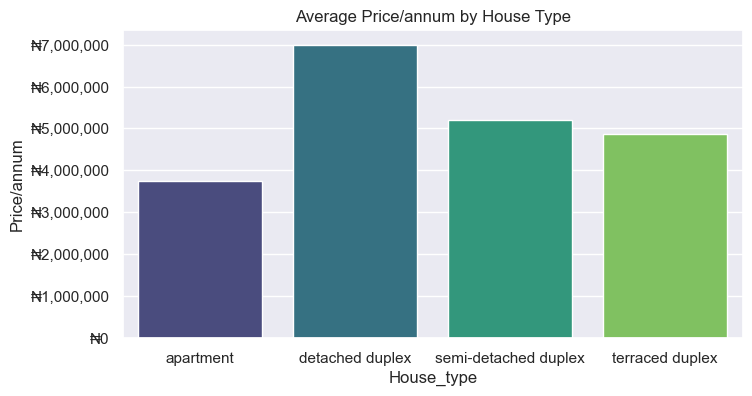

In [66]:

house_type_group = df1.groupby('House_type')['Price/annum'].mean().reset_index()
plt.figure(figsize=(8, 4))
sns.barplot(x='House_type', y='Price/annum', data=house_type_group, palette='viridis')
plt.title('Average Price/annum by House Type')

# formating the y-axis labels
def currency(x, pos):
    'The two args are the value and tick position'
    return '₦{:,.0f}'.format(x)

formatter = FuncFormatter(currency)
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()

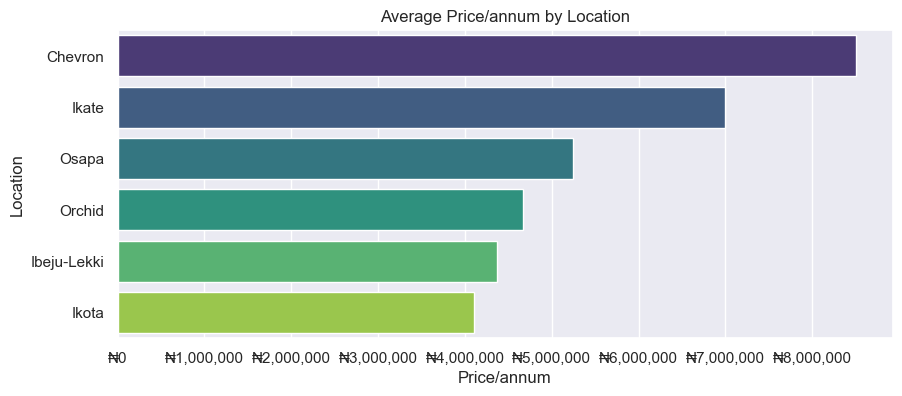

In [67]:
# Grouping by Location 
location_group = df1.groupby('Location')['Price/annum'].mean().reset_index()

plt.figure(figsize=(10, 4))
sns.barplot(x='Price/annum', y='Location', data=location_group.sort_values(by='Price/annum', ascending=False), palette='viridis')
plt.title('Average Price/annum by Location')
plt.gca().xaxis.set_major_formatter(formatter)

plt.show()

## STEP 5: DATA PREPROCESSING

In [69]:
df1

,House_type,Bedrooms,Bathrooms,Toilets,Parking Spaces,Location,Price/annum
0,terraced duplex,3,3,4,2.0,Orchid,4700000
1,terraced duplex,3,3,4,2.0,Osapa,4000000
2,detached duplex,5,5,5,4.0,Chevron,7000000
3,terraced duplex,4,4,5,3.0,Ikota,4000000
4,semi-detached duplex,4,4,4,0.0,Ibeju-Lekki,4500000
...,...,...,...,...,...,...,...
4783,apartment,2,2,3,0.0,Ibeju-Lekki,3500000
4784,apartment,2,2,3,2.0,Ikate,4000000
4785,semi-detached duplex,4,4,5,0.0,Orchid,7000000
4786,terraced duplex,3,3,3,2.0,Ikota,3500000


In [70]:
# Applying one hot encoding of the categorical variables
df1 = pd.get_dummies(df1, columns=['House_type','Location'], drop_first=True)
df1

,Bedrooms,Bathrooms,Toilets,Parking Spaces,Price/annum,House_type_detached duplex,House_type_semi-detached duplex,House_type_terraced duplex,Location_Ibeju-Lekki,Location_Ikate,Location_Ikota,Location_Orchid,Location_Osapa
0,3,3,4,2.0,4700000,False,False,True,False,False,False,True,False
1,3,3,4,2.0,4000000,False,False,True,False,False,False,False,True
2,5,5,5,4.0,7000000,True,False,False,False,False,False,False,False
3,4,4,5,3.0,4000000,False,False,True,False,False,True,False,False
4,4,4,4,0.0,4500000,False,True,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4783,2,2,3,0.0,3500000,False,False,False,True,False,False,False,False
4784,2,2,3,2.0,4000000,False,False,False,False,True,False,False,False
4785,4,4,5,0.0,7000000,False,True,False,False,False,False,True,False
4786,3,3,3,2.0,3500000,False,False,True,False,False,True,False,False


In [71]:
X = df1.drop('Price/annum', axis=1)
y = df1['Price/annum']

In [72]:
X['Rooms'] = df['Bedrooms'] + df['Bathrooms']
X[['Bathrooms', 'Bedrooms', 'Rooms']]

,Bathrooms,Bedrooms,Rooms
0,3,3,6
1,3,3,6
2,5,5,10
3,4,4,8
4,4,4,8
...,...,...,...
4783,2,2,4
4784,2,2,4
4785,4,4,8
4786,3,3,6


In [73]:
# Observation: 

#### CHECKING FEATURE IMPORTANCE FOR ALL THE CATEGORY OF FEATURES USING MUTUAL INFORMATION REGRESSION

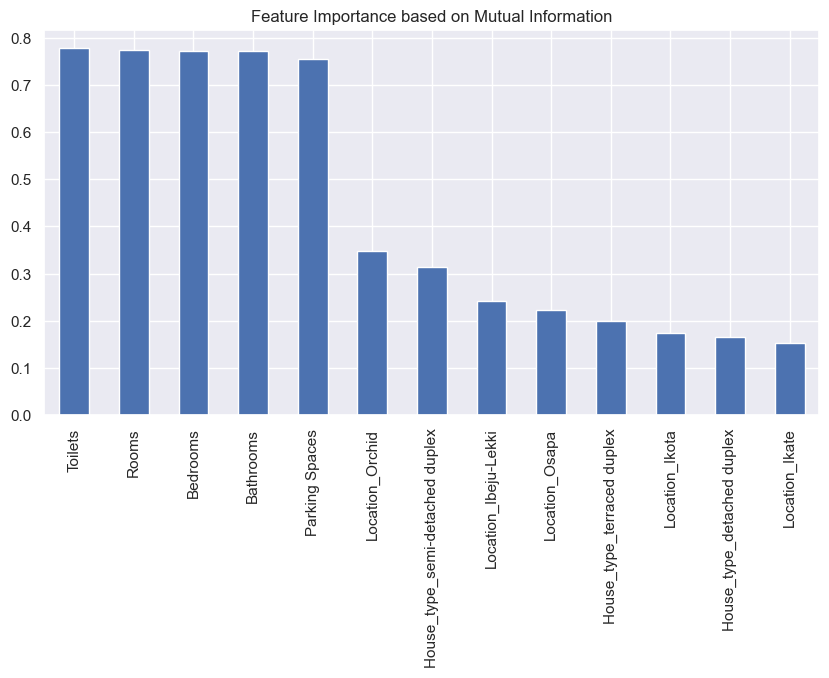

In [75]:
# Compute mutual information
mi = mutual_info_regression(X, y)
mi = pd.Series(mi, index=X.columns)
mi.sort_values(ascending=False).plot.bar(figsize=(10, 5))
plt.title('Feature Importance based on Mutual Information')
plt.show()

In [76]:
mi

Bedrooms                           0.772529
Bathrooms                          0.771593
Toilets                            0.778017
Parking Spaces                     0.755727
House_type_detached duplex         0.165083
House_type_semi-detached duplex    0.313550
House_type_terraced duplex         0.199241
Location_Ibeju-Lekki               0.241800
Location_Ikate                     0.151847
Location_Ikota                     0.173926
Location_Orchid                    0.347165
Location_Osapa                     0.221797
Rooms                              0.773951
dtype: float64

In [77]:
# Observation:

X = X.drop(['Bedrooms', 'Bathrooms'], axis = 1)

In [80]:
# Splitting the data into training, validation and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_hold_test, y_val, y_hold_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)


print(X_hold_test.shape)
print(X_val.shape)
print(X_train.shape)

(434, 13)
(433, 13)
(3465, 13)


In [81]:
# Observation

In [82]:
house_col_name = X_train.columns

## STEP 6: MODEL TRAINING

#### USING LINEAR REGRESSION

In [91]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error

In [92]:
lr = LinearRegression()

In [94]:
lr.fit(X_train, y_train)

LinearRegression()

In [95]:
y_pred_train = lr.predict(X_train)
y_pred_val = lr.predict(X_val)

In [97]:
# Calculate training and testing errors
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_val, y_pred_val)

mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
mape_test = mean_absolute_percentage_error(y_val, y_pred_val)

mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_val, y_pred_val)

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_val, y_pred_val)



print(f"Training MSE: {mse_train:.2f}")
print(f"Testing MSE: {mse_test:.2f}")

print(f"Training MAE: {mae_train:.2f}")
print(f"Testing MAE: {mae_test:.2f}")

print(f"Training MAPE: {mape_train:.2f}")
print(f"Testing MAPE: {mape_test:.2f}")

print(f"Training R²: {r2_train:.2f}")
print(f"Testing R²: {r2_test:.2f}")

Training MSE: 516390262450.21
Testing MSE: 524487239235.28
Training MAE: 587917.87
Testing MAE: 593628.28
Training MAPE: 0.13
Testing MAPE: 0.13
Training R²: 0.87
Testing R²: 0.88


In [99]:
# Combine actual and predicted values into a single DataFrame
lr_combined_data = pd.DataFrame({
    'Actual': y_val,
    'Predicted': y_pred_val
})
lr_combined_data.head()

,Actual,Predicted
528,4000000,4.435382e+06
93,6500000,5.868015e+06
2012,4000000,5.065882e+06
886,4500000,4.605843e+06
1665,3000000,4.016433e+06


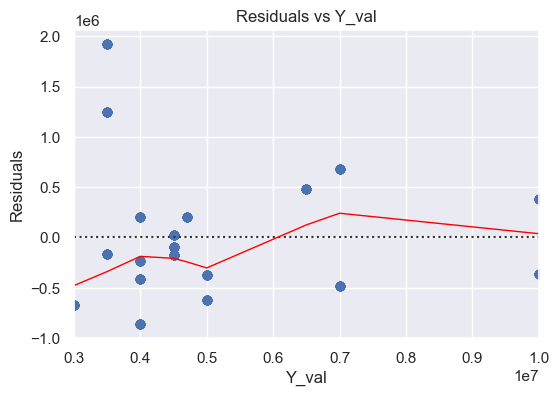

In [100]:
# Plotting the residuals
residuals = y_val - y_pred_val

# Plot residuals
plt.figure(figsize=(6, 4))
sns.residplot(x=y_val, y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 1})
plt.xlabel('Y_val')
plt.ylabel('Residuals')
plt.title('Residuals vs Y_val')
plt.show()


#### USING RIDGE REGRESSION

In [102]:
from sklearn.linear_model import Ridge

In [104]:
ridge = Ridge(alpha=0.1)

In [105]:
ridge.fit(X_train, y_train)

Ridge(alpha=0.1)

In [106]:
ridge_train_pred = ridge.predict(X_train)
ridge_val_pred = ridge.predict(X_val)

In [107]:
ridge_train_mae = mean_absolute_error(y_train, ridge_train_pred)
ridge_test_mae = mean_absolute_error(y_val, ridge_val_pred)
ridge_train_mape = np.mean(np.abs((y_train - ridge_train_pred) / y_train))
ridge_test_mape = np.mean(np.abs((y_val - ridge_val_pred) / y_val))
ridge_train_mse = mean_squared_error(y_train, ridge_train_pred)
ridge_test_mse = mean_squared_error(y_val, ridge_val_pred)
ridge_train_r2 = r2_score(y_train, ridge_train_pred)
ridge_test_r2 = r2_score(y_val, ridge_val_pred)

print(f"Ridge Regression Training MAE: {ridge_train_mae:.2f}")
print(f"Ridge Regression Testing MAE: {ridge_test_mae:.2f}")

print(f"Ridge Regression Training MAPE: {ridge_train_mape:.2f}")
print(f"Ridge Regression Testing MAPE: {ridge_test_mape:.2f}")

print(f"Ridge Regression Training MSE: {ridge_train_mse:.2f}")
print(f"Ridge Regression Testing MSE: {ridge_test_mse:.2f}")

print(f"Ridge Regression Training R²: {ridge_train_r2:.2f}")
print(f"Ridge Regression Testing R²: {ridge_test_r2:.2f}")


Ridge Regression Training MAE: 588588.40
Ridge Regression Testing MAE: 594726.73
Ridge Regression Training MAPE: 0.13
Ridge Regression Testing MAPE: 0.13
Ridge Regression Training MSE: 516413691121.86
Ridge Regression Testing MSE: 524899048294.20
Ridge Regression Training R²: 0.87
Ridge Regression Testing R²: 0.88


In [108]:
# Combine actual and predicted values into a single DataFrame
rg_combined_data = pd.DataFrame({
    'Actual': y_val,
    'Predicted': ridge_val_pred
})
rg_combined_data

,Actual,Predicted
528,4000000,4.440667e+06
93,6500000,5.874700e+06
2012,4000000,5.067028e+06
886,4500000,4.600124e+06
1665,3000000,4.019328e+06
...,...,...
2315,4500000,4.739187e+06
3974,4500000,4.739187e+06
2560,3500000,1.851643e+06
2693,4500000,4.739187e+06


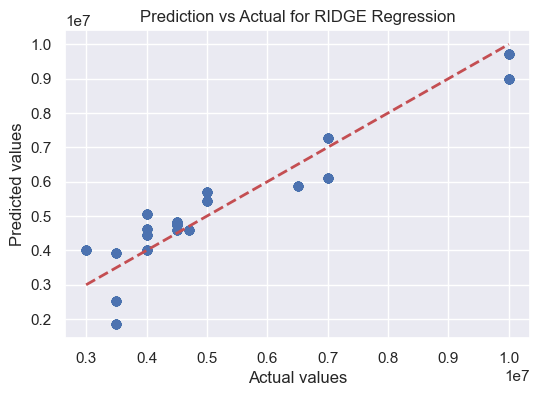

In [109]:
#Plotting the actual against the predicted value
plt.figure(figsize=(6, 4))
plt.scatter(y_val, ridge_val_pred, alpha=0.6)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Prediction vs Actual for RIDGE Regression')
plt.show()

### **USING LASSO REGRESSION**

In [113]:
from sklearn.linear_model import Lasso

In [114]:
lasso = Lasso(alpha=1.0)

In [115]:
lasso.fit(X_train, y_train)

Lasso()

In [116]:
lasso_train_pred = lasso.predict(X_train)
lasso_val_pred = lasso.predict(X_val)

In [118]:
lasso_train_mape = np.mean(np.abs((y_train - lasso_train_pred) / y_train))
lasso_test_mape = np.mean(np.abs((y_val - lasso_val_pred) / y_val))
lasso_train_mae = mean_absolute_error(y_train, lasso_train_pred)
lasso_test_mae = mean_absolute_error(y_val, lasso_val_pred)
lasso_train_mse = mean_squared_error(y_train,lasso_train_pred)
lasso_test_mse = mean_squared_error(y_val, lasso_val_pred)
lasso_train_r2 = r2_score(y_train, lasso_train_pred)
lasso_test_r2 = r2_score(y_val, lasso_val_pred)

print(f"Lasso Regression Training MAPE: {lasso_train_mape:.2f}")
print(f"Lasso Regression Testing MAPE: {lasso_test_mape:.2f}")
print(f"Lasso Regression Training MAE: {lasso_train_mae:.2f}")
print(f"Lasso Regression Testing MAE: {lasso_test_mae:.2f}")
print(f"Lasso Regression Training MSE: {lasso_train_mse:.2f}")
print(f"Lasso Regression Testing MSE: {lasso_test_mse:.2f}")
print(f"Lasso Regression Training R²: {lasso_train_r2:.2f}")
print(f"Lasso Regression Testing R²: {lasso_test_r2:.2f}")


Lasso Regression Training MAPE: 0.13
Lasso Regression Testing MAPE: 0.13
Lasso Regression Training MAE: 587924.12
Lasso Regression Testing MAE: 593639.18
Lasso Regression Training MSE: 516390265113.48
Lasso Regression Testing MSE: 524491551916.77
Lasso Regression Training R²: 0.87
Lasso Regression Testing R²: 0.88


In [119]:
# Combine actual and predicted values into a single DataFrame
combined_data = pd.DataFrame({
    'Actual': y_val,
    'Predicted': lasso_val_pred
})
combined_data

,Actual,Predicted
528,4000000,4.435439e+06
93,6500000,5.868089e+06
2012,4000000,5.065902e+06
886,4500000,4.605781e+06
1665,3000000,4.016463e+06
...,...,...
2315,4500000,4.731729e+06
3974,4500000,4.731729e+06
2560,3500000,1.852427e+06
2693,4500000,4.731729e+06


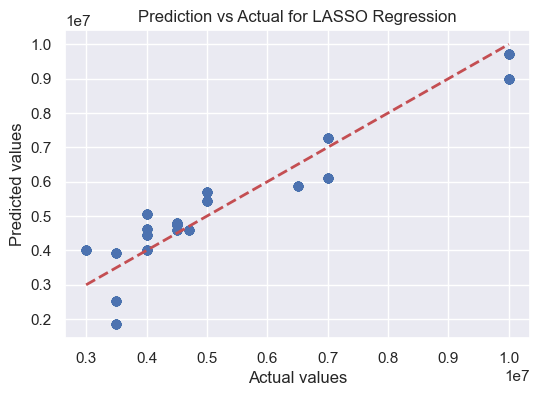

In [120]:
plt.figure(figsize=(6, 4))
plt.scatter(y_val, lasso_val_pred, alpha=0.6)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Prediction vs Actual for LASSO Regression')
plt.show()

### **Using Polynomial Features**

In [124]:
from sklearn.preprocessing import PolynomialFeatures


# Converting Features to their polynomial on 2nd Degree
poly = PolynomialFeatures(degree = 1,include_bias = False )

poly.fit(X_train)

p_train = poly.transform(X_train)
p_val = poly.transform(X_val)
p_test = poly.transform(X_hold_test)

In [125]:
plr = LinearRegression()

In [126]:
plr.fit(p_train, y_train)

LinearRegression()

In [127]:
p_train_pred = plr.predict(p_train)
p_val_pred = plr.predict(p_val)

In [128]:
p_train_mape = np.mean(np.abs((y_train - p_train_pred) / y_train))
p_val_mape = np.mean(np.abs((y_val - p_val_pred) / y_val))

p_train_mae = mean_absolute_error(y_train, p_train_pred)
p_val_mae = mean_absolute_error(y_val, p_val_pred)

p_train_mse = mean_squared_error(y_train, p_train_pred)
p_val_mse = mean_squared_error(y_val, p_val_pred)

p_train_r2 = r2_score(y_train, p_train_pred)
p_val_r2 = r2_score(y_val, p_val_pred)

print(f"Polynomial regression Training MAE: {p_train_mae:.2f}")
print(f"Polynomial regression Testing MAE: {p_val_mae:.2f}")

print(f"Polynomial Regression Training MAPE: {p_train_mape:.2f}")
print(f"Polynomial Regression Testing MAPE: {p_val_mape:.2f}")

print(f"Polynomial Regression Training MSE: {p_train_mse:.2f}")
print(f"Polynomial Regression Testing MSE: {p_val_mse:.2f}")

print(f"Polynomial Regression Training R²: {p_train_r2:.2f}")
print(f"Polynomial Regression Testing R²: {p_val_r2:.2f}")


Polynomial regression Training MAE: 587917.87
Polynomial regression Testing MAE: 593628.28
Polynomial Regression Training MAPE: 0.13
Polynomial Regression Testing MAPE: 0.13
Polynomial Regression Training MSE: 516390262450.21
Polynomial Regression Testing MSE: 524487239235.28
Polynomial Regression Training R²: 0.87
Polynomial Regression Testing R²: 0.88


In [130]:
# Combining all actual and all model predicted values into a single DataFrame
all_combined_data = pd.DataFrame({
    'Actual': y_val,
    'Predicted by lr': y_pred_val,
    'Predicted by Ridge': ridge_val_pred,
    'Predicted by lasso': lasso_val_pred,
    'Predicted by Polynomial regression': p_val_pred
})
all_combined_data

,Actual,Predicted by lr,Predicted by Ridge,Predicted by lasso,Predicted by Polynomial regression
528,4000000,4.435382e+06,4.440667e+06,4.435439e+06,4.435382e+06
93,6500000,5.868015e+06,5.874700e+06,5.868089e+06,5.868015e+06
2012,4000000,5.065882e+06,5.067028e+06,5.065902e+06,5.065882e+06
886,4500000,4.605843e+06,4.600124e+06,4.605781e+06,4.605843e+06
1665,3000000,4.016433e+06,4.019328e+06,4.016463e+06,4.016433e+06
...,...,...,...,...,...
2315,4500000,4.731653e+06,4.739187e+06,4.731729e+06,4.731653e+06
3974,4500000,4.731653e+06,4.739187e+06,4.731729e+06,4.731653e+06
2560,3500000,1.852440e+06,1.851643e+06,1.852427e+06,1.852440e+06
2693,4500000,4.731653e+06,4.739187e+06,4.731729e+06,4.731653e+06


In [136]:
df['Price/annum'].mean()

5628571.428571428

In [140]:
models = [lr, ridge, lasso]
results_list = []

for model in models:
    y_pred = model.predict(X_hold_test)

    mape = np.mean(np.abs((y_hold_test - y_pred) / y_hold_test))
    mae = mean_absolute_error(y_hold_test, y_pred)
    mse = mean_squared_error(y_hold_test, y_pred)
    r2 = r2_score(y_hold_test, y_pred)
    rmse = root_mean_squared_error(y_hold_test, y_pred)


    results_list.append({
        'Model': model,
        'Mean_Absolute_%_Error': mape,
        'Mean_absolute_error': mae,
        'Mean_squared_error': mse,
        'R2_score': r2,
        'Root_Mean_squared_error': rmse
    })

y_poly_pred = plr.predict(p_test)

mape = np.mean(np.abs((y_hold_test - y_poly_pred) / y_hold_test))
mae = mean_absolute_error(y_hold_test, y_poly_pred)
mse = mean_squared_error(y_hold_test, y_poly_pred)
r2 = r2_score(y_hold_test, y_poly_pred)
rmse = np.sqrt(mse)

results_list.append({
    'Model': f'PolynomialRegression(degree= 1)',
    'Mean_Absolute_%_Error': mape,
    'Mean_absolute_error': mae,
    'Mean_squared_error': mse,
    'R2_score': r2,
    'Root_Mean_squared_error': rmse
})

results = pd.DataFrame(results_list)
results

,Model,Mean_Absolute_%_Error,Mean_absolute_error,Mean_squared_error,R2_score,Root_Mean_squared_error
0,LinearRegression(),0.130630,576654.335766,5.174441e+11,0.868221,719335.852224
1,Ridge(alpha=0.1),0.130751,577299.370817,5.174169e+11,0.868228,719316.996150
2,Lasso(),0.130631,576660.550359,5.174442e+11,0.868221,719335.909395
3,PolynomialRegression(degree= 1),0.130630,576654.335766,5.174441e+11,0.868221,719335.852224


In [ ]:
import joblib
joblib.dump(lr, 'house_model.pkl')
joblib.dump(house_col_name, "house_col_name.pkl")

In [177]:
house_model = joblib.load('house_model.pkl')
house_col_name  = joblib.load("house_col_name.pkl")

In [320]:
df1.head(1)

,Bedrooms,Bathrooms,Toilets,Parking Spaces,Price/annum,House_type_house,House_type_semi-detached duplex,House_type_terraced duplex,Location_Ikate,Location_Ikota,Location_Lekki,Location_Orchid,Location_Osapa
0,3,3,4,2.0,4700000,False,False,True,False,False,False,True,False
1,3,3,4,2.0,4000000,False,False,True,False,False,False,False,True
2,5,5,5,4.0,7000000,False,False,False,False,False,False,False,False
3,4,4,5,3.0,4000000,False,False,True,False,True,False,False,False
4,4,4,4,0.0,4500000,False,True,False,False,False,True,False,False
5,4,4,4,0.0,4500000,False,False,True,False,False,True,False,False
6,4,4,4,0.0,3000000,False,True,False,False,False,False,True,False
8,3,3,4,3.0,4000000,False,False,False,False,False,False,True,False
9,5,5,6,3.0,6500000,False,True,False,False,False,False,False,True
11,5,5,6,3.0,10000000,False,False,False,False,False,False,False,False


In [322]:
def make_prediction(model, col_name, house_type, location, bedroom, bathroom, toilet, parking_space):

    cat_df = pd.DataFrame([[house_type, location]],
                          columns=['House_type', 'Location'])
    cat_encoded = pd.get_dummies(cat_df, drop_first=True)

    num_df = pd.DataFrame([[bedroom, bathroom, toilet, parking_space]],
                          columns=['Bedrooms', 'Bathrooms', 'Toilets', 'Parking Spaces'])
    num_df['Rooms'] = num_df['Bedrooms'] * num_df['Bathrooms']

    comb_df = pd.concat([num_df, cat_encoded], axis=1)
    comb_df = comb_df.reindex(columns=col_name, fill_value=0)
   
    # Extract values from combined DataFrame
    price = comb_df.values
    prediction = model.predict(price)
    
    return f'The house rent price for the selected Location will be around {prediction[0]}'

<Axes: xlabel='Bathrooms', ylabel='Price/annum'>

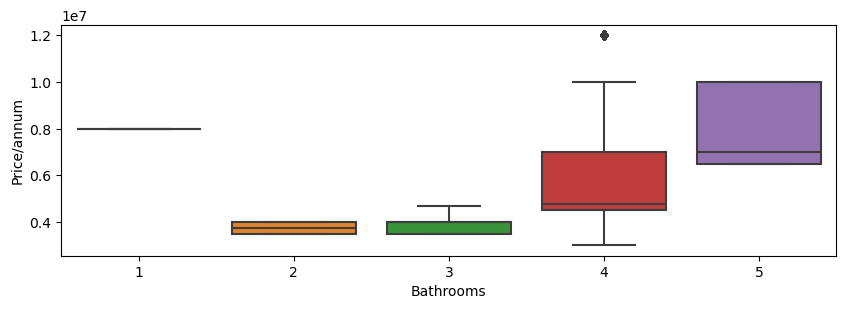

In [99]:
# Let us explore the relationship between PRICE/annum AND Bathrooms.
plt.figure(figsize=(10,3))
sns.boxplot(data = df,y='Price/annum',x='Bathrooms')

In [100]:
# Observation:

<Axes: xlabel='Toilets', ylabel='Price/annum'>

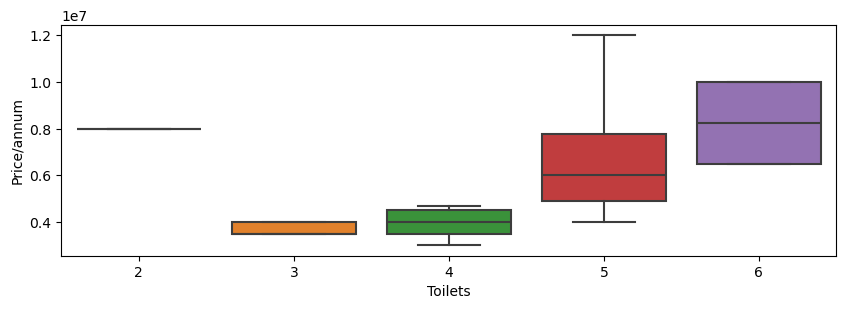

In [101]:
# Let us explore the relationship between PRICE/annum AND Toilets.
plt.figure(figsize=(10,3))
sns.boxplot(data = df,y='Price/annum',x='Toilets')

In [102]:
# Observation:

<Axes: xlabel='Parking Spaces', ylabel='Price/annum'>

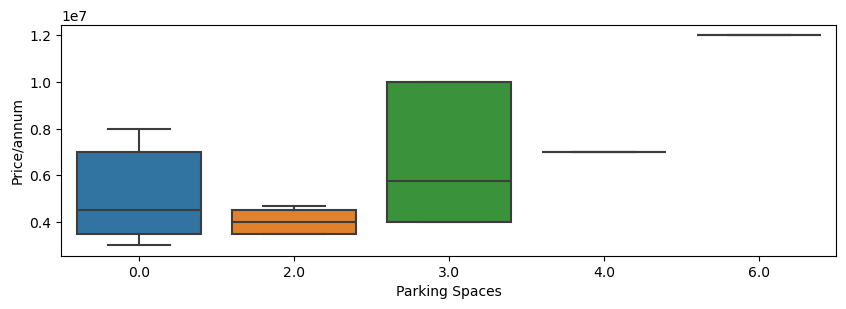

In [103]:
# Let us explore the relationship between PRICE/annum AND Parking Spaces.
plt.figure(figsize=(10,3))
sns.boxplot(data = df,y='Price/annum',x='Parking Spaces')

In [104]:
# Observation: